<img src="img/banner.png" alt="Deparatemento de Ingeniería de Sistemas y Computación, Universidad de los Andes">

# Introducción al Open Data Cube

**Introducción**

El Open Data Cube es un conjunto de librerías que facilitan el proceso de **Organización**, **Consulta** y **Recuperación** de información de imágenes de satélite. En la presente practica relizaremos el proceso de consulta y análisis de una imágen satelital mediante las funcionalidades que ofrece el ODC.

**Objetivo**



**Contenido**

1. Instalar librerías de Python
2. importar librerías
3. Consulta del área de estudio
4. Características de la imágen obtenida
5. Aplicación de un algoritmo de análisis
6. Visualización de resultados

## 1. Instalar librerías de Python

En esta sección instalaremos la librería `geopython` esta librería nos permitira cargar polígonos en formato KML en Python. Para instalar una librería podemos usa el commando 

`pip3 install <nombre librería de python>`

Una vez la libería es instalada es necesario reiniciar el Kernel de Jupyter. Para ello debe ir a la `barra de heramientas -> Kernel -> Restart Kernel...`. Luego en la opción `Restart`.

In [ ]:
!pip3 install geopandas

## 2. Importar librerías

En esta sección se importan las librerías cuya funicionalidades particulares son requeridas.

In [1]:
# las funcionalidades del open data cube son accedidas 
# por medio de la librería datacube
import datacube

# Librería usada para la carga de polígonos
import geopandas as gpd

# Librería usada para visualización de datos
import matplotlib.pyplot as plt

# Desactiva los warnings en el notebook
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Configuración de Drivers para leer polígonos en formato KMLs
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

## 2. Consulta del área de estudio

(Opción 1) Consultar un área a partir de un polígono

    latitude=(5.482742764560578, 5.599560141454585),
    longitude=(-72.98455102539063, -72.86891119384765),


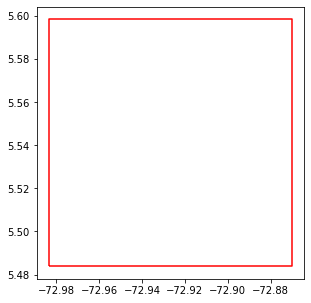

In [16]:
# Carga del archivo .kml
df_polygon = gpd.read_file("polygon/tota_lake.kml",driver='KML')
df_polygon = df_polygon.to_crs('EPSG:4326')

# Pintar el polígono seleccionado
fig, ax = plt.subplots(figsize=(5,5))
df_polygon.boundary.plot(ax=ax,color='red')

# Obtención de la geometría del polígono del GeoDataFrame
geometry_predio = df_polygon['geometry'][0]

# Obtención de los límites del cuadrado que enmarca el polígono
minx, miny, maxx, maxy = geometry_predio.bounds

# Aumento del aŕea del cuadrado para "EPSG:32719"
buffer = 0.001

minx = minx - buffer
miny = miny - buffer
maxx = maxx + buffer
maxy = maxy + buffer

# Parámetros de área a ser consultada
set_study_area_lat = (miny,maxy)
set_study_area_lon = (minx,maxx)

print(f'    latitude={set_study_area_lat},')
print(f'    longitude={set_study_area_lon},')

(Opción 2) Consultar un área a partir de un punto

Los coordenadas del punto a seleccionar pueden ser obtenidas a travez de herramientas GIS como google maps. Este punto debe estar comprendido en el área que desea estudiar. El punto definido será empleado para la generación de un cuadrado que finalmente será usado para consultar el área de estudio. La variable `buffer` permite ampliar o disminuir las dimensiones del cuadrado. Lo anterior es equivalente a disminuir o ampliar el área de estudio a consultar en el open data cube.

<img src="img/latlong_buffer.png" alt="Definición área de estudio" width="20%">

In [10]:
# Definición de las coordenadas del punto
central_lat = 5.547964746532565
central_lon =  -72.9284962779124

# Aumento del aŕea del cuadrado para "EPSG:4326"
# 11.1 kilómetros
buffer = 0.1

# Calculo del cuadro delimitador (bounding box) para el área de estudio
set_study_area_lat = (central_lat - buffer, central_lat + buffer)
set_study_area_lon = (central_lon - buffer, central_lon + buffer)

print(f'    latitude={set_study_area_lat},')
print(f'    longitude={set_study_area_lon},')

    latitude=(5.447964746532565, 5.647964746532565),
    longitude=(-73.0284962779124, -72.82849627791241),


Carga de información en el Open Data Cube

In [17]:
dc = datacube.Datacube(app="Cana")

dataset = dc.load(
    product="s2_sen2cor_ard_granule_EO3",
    latitude=(5.482742764560578, 5.599560141454585),
    longitude=(-72.98455102539063, -72.86891119384765),
    time=('2021-01-01', '2021-02-01'),
    measurements=["red","blue","green","nir","swir1","swir2","scl"],
    crs="EPSG:4326",
    output_crs="EPSG:4326",
    resolution=(-0.00008983111,0.00008971023)
)

dataset

<xarray.Dataset>
Dimensions:      (latitude: 1302, longitude: 1290, time: 2)
Coordinates:
  * time         (time) datetime64[ns] 2021-01-15T17:44:59 2021-01-30T17:40:15
  * latitude     (latitude) float64 5.6 5.599 5.599 5.599 ... 5.483 5.483 5.483
  * longitude    (longitude) float64 -72.98 -72.98 -72.98 ... -72.87 -72.87
    spatial_ref  int32 4326
Data variables:
    red          (time, latitude, longitude) uint16 595 986 1230 ... 994 1013
    blue         (time, latitude, longitude) uint16 321 490 653 ... 403 447 458
    green        (time, latitude, longitude) uint16 550 770 1072 ... 731 785 769
    nir          (time, latitude, longitude) uint16 2080 2268 2566 ... 2595 2613
    swir1        (time, latitude, longitude) uint16 2538 2732 2732 ... 2872 2872
    swir2        (time, latitude, longitude) uint16 1653 1897 1897 ... 1671 1671
    scl          (time, latitude, longitude) uint8 4 5 5 4 4 5 5 ... 4 4 4 4 4 4
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

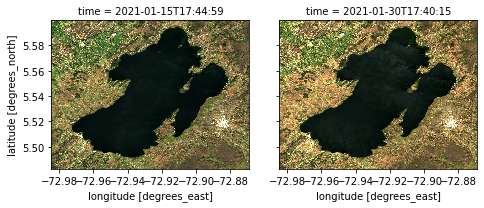

In [18]:
rgb = dataset[["red","green","blue"]].to_array(dim='color')
rgb = rgb.transpose(*(rgb.dims[1:]+rgb.dims[:1]))  # make 'color' the last dimension
img = rgb.plot.imshow(col='time',col_wrap=2,add_colorbar=False,vmin=0,vmax=1500)

## 3. Características de la imágen obtenida

La función `dc.load` del open datacube recibe una consulta y retorna una estructuar de datos llamada `xarray.Dataset` que contiene toda la información que fue solicitada en la consulta. Un `xarray.Dataset` presenta las siguientes propiedades.

<img src="https://raw.githubusercontent.com/DonAurelio/open-datacube-bac-training/main/docs/xarray.png" alt="xarray.Dataset" width="60%">

**Dimensiones (`Dimensions`)**

Las dimensiones identifican el número de pasos de tiempo devueltos en la búsqueda (`time: 4`), así como el número de píxeles en las dimensiones `latitude` y `longitude`. Además, indica cómo están organizados los datos en las diferentes dimensiones.

**Coordenadas (`Coordinates`)**

* `time` identifica la fecha atribuida a cada intervalo de tiempo devuelto como resultado de la consulta.
* `latitude` y `longitude` son las coordenadas de cada píxel dentro de los límites espaciales de la consulta.

<img src="https://raw.githubusercontent.com/DonAurelio/open-datacube-bac-training/main/docs/numpy_array_shape.png" alt="xarray.Dataset" width="60%">

**Variables de datos (`Data variables`)**

Por cada banda (*measurement*) que representa la información espectral de la imágen hay una *variable de datos*. En el ejemplo anterior, las variables de datos obtenidas son: `red`,`blue`,`green`,`nir`,`swir1`,`swir2`,`scl`. Cada variable de datos es un arreglo de tres dimensiones de tipo `xarray.DataArray`.

**Atributos (`Attributes`)**

* `crs` identifica el sistema de coordenadas de referencia de la imágen obtenida.


### Explolación de las dimensiones

La propiedad `dims` permite visualizar las dimensiones dle dataset.

In [ ]:
dataset.dims

> **TODO:** ¿Cuántos periodos de tiempo retornó la consulta? ¿Cuántos píxeles retorno la consulta?

### Exploración de las coordenadas

La propiedad `coords`permite visualizar las coordenadas. Las coordenadas pueden ser vistas como las etiquetas de los ejes de un cubo de tres dimensiones. En este caso, las dimensiones son `time`, `longitude`, `latitude`.

In [ ]:
dataset.coords

Para conocer de forma explícita qué periodos de tiempo retorno como resultado la consulta

In [ ]:
dataset.coords['time']

Para conocer de forma explícita las coordendas de longitud

In [ ]:
dataset.coords['longitude']

Para conocer de forma explícita las coordendas de latitud

In [ ]:
dataset.coords['latitude']

### Exploración de las variables de datos

La información espectral de una imágen satelital es organizada por el Open Data Cube en *variables de datos*. Cada variable de datos contiene la información de una única banda. La información de cada banda es organizada en un arreglo de tres dimensiones. 

Para acceder a la información espectral de la banda `blue` podemos usar la expresión mostrada a continuación.

In [ ]:
dataset.blue

Dado que cada variable de datos es un arreglo de tres dimensiones, es posible indexar la información del mismo. Es importante conocer el orden de los ejes para determinar de antemáno que información se mostrará al indixar una variable de datos.

Por ejemplo, puedo obtener la primera imágen en el tiempo para la banda `blue`. 

In [ ]:
dataset.blue[0]

En la mayoría de los casos es deseable visualizar los valores en la banda blue para la imagen seleccionada para un periodo de tiempo. A continuación, se mustra cómo obtener una imágen para la banda `blue` para un periodo de tiempo seleccionado.

In [ ]:
dataset.blue[0].plot()

De la misma forma, podría ver el valor para la banda `blue` de un único píxel. Los valores entre corchetes `[1,0,0]` se interpretan considerando el orden de las coordenadas. En este caso:

* la primera coordenada es el tiempo (`time`) de modo que en la matrix se ha seleccionado el periodo de tiempo `1`. 
* la segúnda coodenada es la latitud (`latitude`) de modo que en la matrix se ha selccionado la latitud `0`
* la tercera coordenada es la longitud (`longitude`) así, la longitud seleccionada es `0`

In [ ]:
dataset.blue[1,0,0]

> **TODO:**  Realice el proceso de **Exploración de variables de datos** para las variables (bandas) restantes `red`,`green`,`nir`,`swir1`,`swir2` y `scl`. Cree una nueva celda para cada ejemplo. Puede apoyarse en el ejemplo de exploración de la banda `blue` mostrado anteriormente.

### Exploración de atributos

Entre los atributos que hace parte de los metadatos dela imágen, se muestra el sistema de referencia de coordenadas (CRS) de la imágen obtenida a partir del Open Data Cube. Una de las bondades del Open Data Cube es que permite obtener la información de las imágenes en diferentes sistemas de coordendas y en diferentes dimensiones.

In [ ]:
dataset.crs

## 4. Aplicación de un algoritmo de análisis

El Índice de Vegetación de Diferencia Normalizada (NDVI) cuantifica la salud de la vegetación midiendo la diferencia entre el nir del infrarrojo cercano (que la vegetación refleja fuertemente) y la luz roja (que la vegetación absorbe). Los valores de este índice permiten hacer algúnas interpretaciones de la cobertura.

* Valores negativos: indicio de que hay agua.
* Valores cercanos a 1: existe una alta posibilidad de que la cobertura observada presente hojas verdes densas.
* Valores cercanos a 0: no hay hojas verdes e incluso podría ser una zona urbanizada.

<img src="https://raw.githubusercontent.com/DonAurelio/open-datacube-bac-training/main/docs/ndvi_1.png" alt="Deparatemento de Ingeniería de Sistemas y Computación, Universidad de los Andes" width="40%">

Agracias a la forma en que el Open Data Cube organiza los información expectral de una imágen, es posible realizar calculos como el NDVI de manera sencilla.

In [ ]:
dataset['ndvi'] = (dataset.nir - dataset.red) / (dataset.nir + dataset.red)
dataset

Los resultados del NDVI calculado para todos los periodos de tiempo retornados en la consulta del open data cube se muestra a continuación.

In [ ]:
dataset.ndvi.plot(col='time',col_wrap=4)

Para interpretar los valores del NDVI puede usar los rangos descritos en la imágen mostrada a continuación.

<img src="https://raw.githubusercontent.com/DonAurelio/open-datacube-bac-training/main/docs/ndvi_2.jpg" alt="Deparatemento de Ingeniería de Sistemas y Computación, Universidad de los Andes" width="80%">

## 5. Visualización de resultados

La visualización es uno de los procesos más importantes en el proceso de análisis de una imágen satelital. El open data cube facilita en todos los aspectos el análisis de series de tiempo. Es decir cómo cambiar la información espectral mostrada por la cobertura terrestre en el tiempo. A continuación aprenderémos a desarrollar diferentes tipos de visualizaciones para las imágenes obtenidas a partir de una consulta. 

Imágen en `true color`

In [ ]:
rgb = dataset[["red","green","blue"]].to_array(dim='color')
rgb = rgb.transpose(*(rgb.dims[1:]+rgb.dims[:1]))  # make 'color' the last dimension
img = rgb.plot.imshow(col='time',col_wrap=4,add_colorbar=False,vmin=0,vmax=1500)

Imágen en `true color` con el polígono que se empleó para delimitar el área de consulta

In [ ]:
rgb = dataset[["red","green","blue"]].to_array(dim='color')
rgb = rgb.transpose(*(rgb.dims[1:]+rgb.dims[:1]))  # make 'color' the last dimension
img = rgb.plot.imshow(col='time',col_wrap=4,add_colorbar=False,vmin=0,vmax=1500)

for axes in img.axes.flat:
    df_polygon.boundary.plot(ax=axes,markersize=20,color='blue',marker='o')
plt.show()

Cambio en el tiempo de la información espectral únicamente de la banda `red`.

In [ ]:
dataset.red.plot(col='time',col_wrap=4)

Para cambiar el rango de colores de la visualización mostrada usamos el parámetro `cmap` y le indicamos un rango de color válido. El listado de colores válidos lo puede encontrar [aquí](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html)

In [ ]:
dataset.red.plot(col='time',col_wrap=4,cmap='Reds')

Cambio en el tiempo de la información espectral únicamente de la banda `blue`.

In [ ]:
dataset.blue.plot(col='time',col_wrap=4, cmap='Blues')

> **TODO:**  Realice el proceso de **Visualización** para las variables (bandas) restantes `green`,`nir`,`swir1`,`swir2` y `scl`. Cree una nueva celda para cada ejemplo. Puede apoyarse en el ejemplo de exploración de la banda `blue` mostrado anteriormente. Use los colores `'Greens'` para la banda `green`; para las demás bandas no cambie los colores.